In [12]:
import numpy as np
import copy
import pynn_brainscales.brainscales2 as pynn
from pyNN.standardmodels import build_translations

In [13]:
class Plasticity:
    def __init__(self, projection: pynn.Projection, post_somas: pynn.PopulationView):
        self.projection = projection
        print("inside constructor")
        
        self.permanence_min = np.asarray(np.random.randint(0, 8, size=(len(projection),)), dtype=float)
        self.permanence = copy.copy(self.permanence_min)
        self.permanence_max = 20.
        self.threshold = np.ones((len(projection))) * 20.
        self.lambda_plus = 0.08 * 1e3
        self.tau_plus = 20. / 1e3
        self.lambda_minus = 0.0015 * 1e3
        self.target_rate_h = 1.
        self.lambda_h = 0.014 * 1e3
        self.tau_h = 440. / 1e3
        self.y = 1.
        self.delta_t_min = 4e-3
        self.delta_t_max = 8e-3
        self.dt = 0.1e-3
        self.post_somas = post_somas
        self.mature_weight = 63
        self.debug = False
        print(self.delta_t_min, self.delta_t_max)
        
        self.x = np.zeros((len(projection.pre)))
        self.z = np.zeros((len(projection.post)))
        
    
    def rule(self, permanence, threshold, x, z, runtime, neuron_spikes_pre, neuron_spikes_post, neuron_spikes_post_soma):
        mature = False
        for t in np.linspace(0., runtime, int(runtime / self.dt)):
            if self.debug:
                print(t, round(permanence, 5), round(x, 2), round(z, 2))
            has_pre_spike = any(t <= spike < t + self.dt for spike in neuron_spikes_pre)
            has_post_dendritic_spike = any(t <= spike < t + self.dt for spike in neuron_spikes_post)
            has_post_somatic_spike = any(t <= spike < t + self.dt for spike in neuron_spikes_post)
            I = [sum(self.delta_t_min < (spike_post - spike_pre) < self.delta_t_max for spike_pre in neuron_spikes_pre) for spike_post in neuron_spikes_post_soma]
            has_post_somatic_spike_I = sum((t <= spike < t + self.dt) and I[n] for n, spike in enumerate(neuron_spikes_post_soma))
            x += (- x / self.tau_plus) * self.dt + has_pre_spike
            z += (- z / self.tau_h) * self.dt + has_post_dendritic_spike
            permanence += (self.lambda_plus * x * has_post_somatic_spike_I
                           - self.lambda_minus * self.y * has_pre_spike
                           + self.lambda_h * (self.target_rate_h - z) * has_post_somatic_spike_I) * self.permanence_max * self.dt
            if permanence >= threshold:
                mature = True
        return permanence, x, z, mature

        
            
    def __call__(self, runtime: float):
        if isinstance(projection.pre.celltype, pynn.cells.SpikeSourceArray):
            spikes_pre = projection.pre.get("spike_times").value
            spikes_pre = np.array(spikes_pre)
            if spikes_pre.ndim == 1:
                spikes_pre = np.array([spikes_pre] * len(projection.pre))
        else:
            spikes_pre = projection.pre.get_data("spikes").segments[-1].spiketrains
        spikes_post = projection.post.get_data("spikes").segments[-1].spiketrains
        spikes_post_somas = self.post_somas.get_data("spikes").segments[-1].spiketrains
        weight = projection.get("weight", format="array")
        for c, connection in enumerate(self.projection.connections):
            i = connection.postsynaptic_index
            j = connection.presynaptic_index
            neuron_spikes_pre = spikes_pre[j]
            neuron_spikes_post = np.array(spikes_post[i])
            neuron_spikes_post_soma = np.array(spikes_post_somas[i])
            
            permanence, x, z, mature = self.rule(permanence=self.permanence[c], threshold=self.threshold[c], runtime=runtime, x=self.x[j], z=self.z[i], neuron_spikes_pre=neuron_spikes_pre, neuron_spikes_post=neuron_spikes_post, neuron_spikes_post_soma=neuron_spikes_post_soma)
            self.permanence[c] = permanence
            self.x[j] = x
            self.z[i] = z
            
            if weight[c] != self.mature_weight and mature:
                weight[c] = self.mature_weight
        projection.set(weight=weight)

In [14]:
from _static.common.helpers import setup_hardware_client
setup_hardware_client()

from _static.common.helpers import get_nightly_calibration
calib = get_nightly_calibration()

refractory_clock_scale = 7

for backend in calib.neuron_block.backends:
    backend.clock_scale_fast = refractory_clock_scale
    
period_refractory_clock = 1. / (250e6 / 2**(refractory_clock_scale + 1))
print(period_refractory_clock)

# setup PyNN and inject calibration data
pynn.setup(initial_config=calib)

1.024e-06


In [15]:
input_pop_dendrite = pynn.Population(8, pynn.cells.SpikeSourceArray(spike_times=[14e-3]))

input_pop_soma = pynn.Population(1, pynn.cells.SpikeSourceArray(spike_times=[17e-3]))

all_neurons = pynn.Population(2, pynn.cells.HXNeuron(threshold_v_threshold=300))

dendrite = pynn.PopulationView(all_neurons, [0])
soma = pynn.PopulationView(all_neurons, [1])
                                                                                                                                                             
dendrite.set(
    multicompartment_enable_conductance=True,
    multicompartment_i_bias_nmda=30,
    multicompartment_connect_soma_right=True,
    reset_v_reset=800,
    refractory_period_reset_holdoff=0,
    refractory_period_refractory_time=75,
)
dendrite.record(["spikes"])

soma.set(
    multicompartment_connect_soma=True,
    refractory_period_refractory_time=10,
)
soma.record(["spikes"])

projection = pynn.Projection(input_pop_dendrite, dendrite, pynn.AllToAllConnector(), pynn.standardmodels.synapses.StaticSynapse(weight=0), receptor_type="excitatory")
pynn.Projection(input_pop_soma, soma, pynn.AllToAllConnector(), pynn.standardmodels.synapses.StaticSynapse(weight=200), receptor_type="excitatory")

Projection("population4→view of 'population5' with size 1")

In [16]:
test_projection = pynn.Projection(pynn.PopulationView(input_pop_dendrite, [0]), dendrite, pynn.AllToAllConnector(), pynn.standardmodels.synapses.StaticSynapse(weight=0), receptor_type="excitatory")

plasticity = Plasticity(test_projection, post_somas=soma)

plasticity.debug = False

permanence = 0.
x = 0.
z = 0.
runtime = 0.1

neuron_spikes_pre = np.array([10. / 1e3])
neuron_spikes_post = np.array([12. / 1e3])
neuron_spikes_post_soma = np.array([15. / 1e3])

for i in range(1):
    plasticity.rule(permanence, 20., x, z, runtime, neuron_spikes_pre, neuron_spikes_post, neuron_spikes_post_soma)

inside constructor
0.004 0.008


In [17]:
plasticity = Plasticity(projection, post_somas=soma)
plasticity.debug = False

inside constructor
0.004 0.008


In [18]:
print(plasticity.permanence)
print(plasticity.permanence)

[5. 7. 6. 1. 5. 6. 0. 6.]
[5. 7. 6. 1. 5. 6. 0. 6.]


In [19]:
runtime = 0.1

dendrite_v = []
dendrite_s = []
soma_v = []
soma_s = []

vs = (dendrite_v, soma_v)
spikes = [dendrite_s, soma_s]
permanences = []
x = []
z = []
weight = []

for idx, pop in enumerate([dendrite, soma]):
    pop.record(["v", "spikes"])
    for t in range(200):
        print(t)
        pynn.run(runtime)
        plasticity(runtime)
        vs[idx].append(pop.get_data("v").segments[-1].irregularlysampledsignals[0])
        spikes[idx].append(pop.get_data("spikes").segments[-1].spiketrains)
        permanences.append(copy.copy(plasticity.permanence))
        x.append(plasticity.x[0])
        z.append(plasticity.z[0])
        weight.append(projection.get("weight", format="array"))
    pop.record(None)
    pop.record(["spikes"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


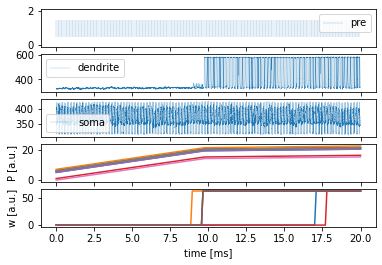

In [25]:
%matplotlib inline

from matplotlib import pyplot as plt

fig, (ax_pre, ax_d, ax_s, ax_p, ax_w) = plt.subplots(5, 1, sharex=True)

times_dendrite = np.concatenate([np.array(vs[0][i].times) + runtime * i for i in range(200)])
vs_dendrite = np.concatenate([np.array(vs[0][i]) for i in range(200)])
times_soma = np.concatenate([np.array(vs[1][i].times) + runtime * i for i in range(200)])
vs_soma = np.concatenate([np.array(vs[1][i]) for i in range(200)])

ax_pre.eventplot(np.concatenate([np.array(input_pop_dendrite.get("spike_times").value) + i * runtime for i in range(200)]), label="pre", lw=.2)
ax_pre.legend()
ax_d.plot(times_dendrite, vs_dendrite, label="dendrite", lw=.2)
ax_d.legend()
ax_s.plot(times_soma, vs_soma, label="soma",lw=.2)
ax_s.legend()
ax_p.plot(np.linspace(0., runtime * 200., 200), permanences[:200], label="permanence")
ax_p.set_ylabel("P [a.u.]")
#ax_p.legend()
ax_w.plot(np.linspace(0., runtime * 200., 200), np.array([w for w in np.array(weight[:200]).squeeze().T if any(w)]).T, label="weight")
ax_w.set_ylabel("w [a.u.]")
#ax_w.legend()
ax_w.set_xlabel("time [ms]")
plt.savefig("plasticity.pdf")